In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import lmfit
import ompy as om
import json

import scipy.stats as stats
import sys

#%matplotlib widget
from ipywidgets import widgets #interact, interactive, fixed, interact_manual

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
from ipynb.fs.full.functions import *

In [3]:
plt.rcParams["figure.dpi"] = 80
plt.rcParams["errorbar.capsize"] = 5
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['font.size'] = 25
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['text.usetex'] = True

In [4]:
om.__full_version__;
np.random.seed(1382398)

In [5]:
gsf_values = read_OMPy('02-23_13:03:23')[0]
energy_gsf_ompy = np.asarray(gsf_values[0])
gsf_ompy_median = np.asarray(gsf_values[1])
gsf_ompy_error = np.asarray(gsf_values[4])


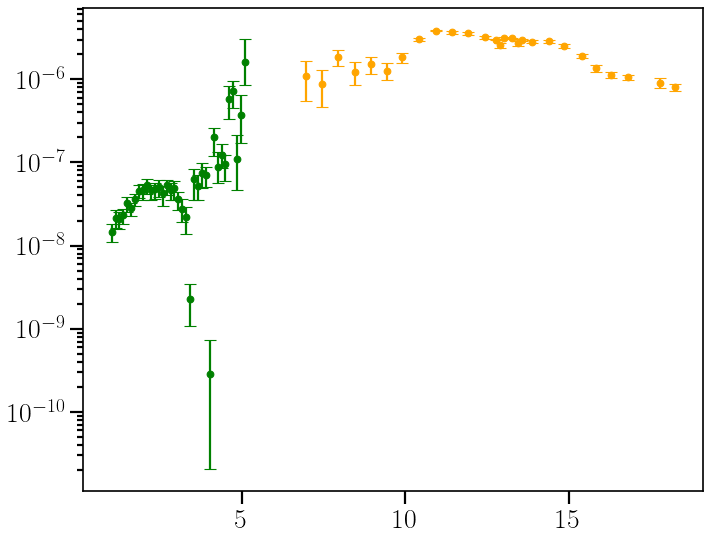

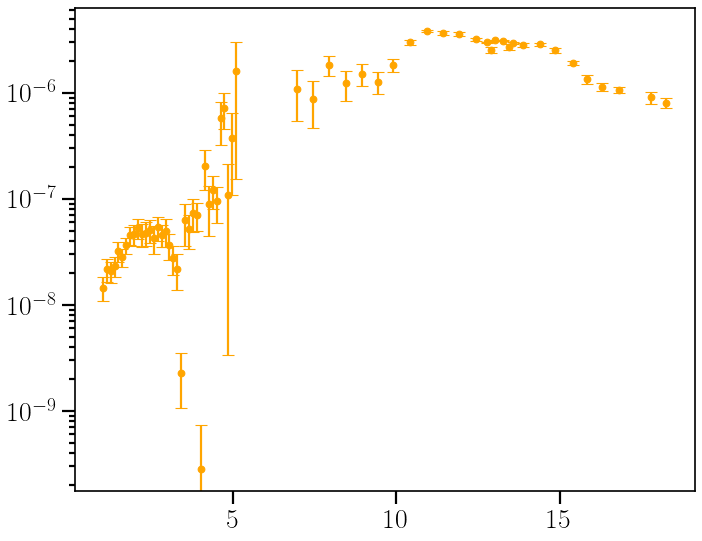

In [6]:
#with open('plotting/exfor_data/u233_g_x.json') as K:
with open('u233_g_x.json') as K:
    data_U233 = json.load(K)
datasets_U233=data_U233["datasets"]

energy_exp1, gsf_exp1, gsf_exp1_error =  extract_JSON(datasets_U233[0]['data'], 5, 0, 1)
gsf_exp1 = cs_to_gsf(energy_exp1, gsf_exp1)
gsf_exp1_error = cs_to_gsf(energy_exp1, gsf_exp1_error)

fig, ax = plt.subplots()
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, fmt='o', color='green')
ax.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='o', color='orange')
ax.set_yscale('log')
fig.show()

#pasting all data together

#y_error_lower = np.concatenate([gsf_ompy_error[0], np.asarray(gsf_exp1_error/2)])
#y_error_upper = np.concatenate([gsf_ompy_error[1], np.asarray(gsf_exp1_error/2)])
#y_errors = [y_error_lower, y_error_upper]

#changing the errors, to one array instead of two
gsf_ompy_error_new = np.zeros(len(gsf_ompy_error[0]))
for i in range(len(gsf_ompy_error[0])):
    gsf_ompy_error_new[i] = max([gsf_ompy_error[0][i], gsf_ompy_error[1][i]])
gsf_ompy_error = gsf_ompy_error_new
y_errors = np.concatenate([gsf_ompy_error, gsf_exp1_error])


x_values = np.concatenate([energy_gsf_ompy, energy_exp1])
y_values = np.concatenate([gsf_ompy_median, gsf_exp1])

fig, ax = plt.subplots()
ax.errorbar(x=x_values, y=y_values, yerr=y_errors, fmt='o', color='orange')
ax.set_yscale('log')
fig.show()

In [7]:
#declaring fit parameters

#Define parameters & start values for the GLO
E_GLo1 = 11.4 # centroid (MeV)
Gamma_GLo1 = 2.0 # width (MeV)
sigma_GLo1 = 300 # peak cross section (mb)
E_GLo2 = 14.0 # centroid (MeV)
Gamma_GLo2 = 4.3 # width (MeV)
sigma_GLo2 = 480 # peak cross section (mb)
T_f    = 0.2 #constant temperature of final states (MeV)

#START VALUES pygmy resonance 1
E_pyg1 = 4.5 # Pygmy centroid (MeV)
Gamma_pyg1 = 0.4 # Width (MeV)
sigma_pyg1 = 5.0 #peak cross section (mb)

#START VALUES pygmy 2/spinflip resonance
E_pyg2 = 7.0 #Pygmy centroid (MeV) - this is from systematics (taken from TALYS)
Gamma_pyg2 = 1.5 #Width (MeV)
sigma_pyg2 = 20.0 #peak cross section (mb)

#START VALUES Pygmy scissors resonance
E_SR = 2.5 #Pygmy centroid (MeV) - this is from systematics (taken from TALYS)
Gamma_SR = 1.5 #Width (MeV)
sigma_SR = 1.0 #peak cross section (mb)


p0 = [T_f, E_GLo1, Gamma_GLo1, sigma_GLo1,
      E_GLo2, Gamma_GLo2, sigma_GLo2,
      E_pyg1, Gamma_pyg1, sigma_pyg1,
      E_pyg2, Gamma_pyg2, sigma_pyg2,
      E_SR, Gamma_SR, sigma_SR]
p0_functions = [GLo, GLo, SLo, SLo, SLo]
p0_functions_names = ['GLo1', 'GLo2', 'pyg1', 'pyg2', 'SR']
nuclei = "233U"

In [8]:
minimum = np.array(p0)*0.3
maximum = np.array(p0)*2.5

Name           Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_GLo1         11.47     3.42     28.5   0.1973     True     None     None
E_GLo2          14.1      4.2       35  0.07856     True     None     None
Gamma_GLo1     2.733      0.6        5   0.7798     True     None     None
Gamma_GLo2      2.87     1.29    10.75   0.7382     True     None     None
T_f              0.5     0.06      0.5   0.8306     True     None     None
sigma_GLo1       484       90      750      107     True     None     None
sigma_GLo2     301.5      144     1200    67.01     True     None     None
None


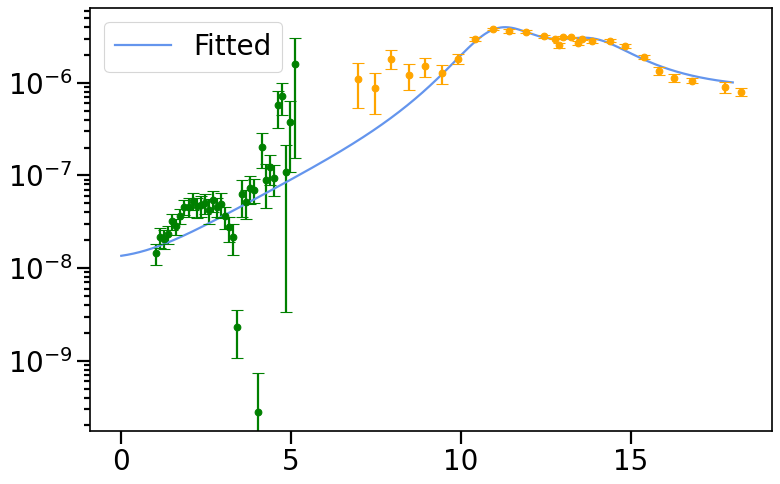

In [9]:
params_GLo = lmfit.Parameters()

#                (Name,          Value,  Weather or not to include in fit, 
#                 |              |       |     Lower fit limit, 
#                 |              |       |     |            Upper fit limit)
params_GLo.add_many(('T_f',          p0[0],  True, minimum[0],  maximum[0]),
                    ('E_GLo1',       p0[1],  True, minimum[1],  maximum[1]),
                    ('Gamma_GLo1',   p0[2],  True, minimum[2],  maximum[2]),
                    ('sigma_GLo1',   p0[3],  True, minimum[3],  maximum[3]),
                    ('E_GLo2',       p0[4],  True, minimum[4],  maximum[4]),
                    ('Gamma_GLo2',   p0[5],  True, minimum[5],  maximum[5]),
                    ('sigma_GLo2',   p0[6],  True, minimum[6],  maximum[6]),)

low_cut_GLo = 0
def f_fit_GLo(par, E = energy_exp1[low_cut_GLo:]):
    """ Marianne: make_fit currently supports up to 5 GLO/SLOs. To add more, continue the pattern. This 
    was, suprisingly, the best solution I found atm working with the scipy-syntax. """

    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2']])

    # Calculating the sum of the singular GLOs
    output = np.zeros(len(E))
    for i in range(2):
        output += functions[i](E, EX[i], Gamma[i], sigma[i], T)
    return output

def f_residuals(parameters):
    return (f_fit_GLo(parameters) - gsf_exp1[low_cut_GLo:])**2/(gsf_exp1_error[low_cut_GLo:]**2)

results = lmfit.minimize(fcn=f_residuals, params=params_GLo, method="least_squares")
print(results.params.pretty_print())

plt.rcParams['text.usetex'] = False
# Initialize figure!
plt.figure(figsize=(11,7))
ax = plt.subplot(111)


# Actual best-fit curve
# Extract values from the fit
# Plot the total optimalized fit
x_values_cont = np.linspace(0, 18, 1000)
plot_fit = ax.plot(x_values_cont, f_fit_GLo(results.params, E=x_values_cont), '-', color="cornflowerblue", label="Fitted")
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, fmt='o', color='green')
ax.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='o', color='orange')
ax.legend()
ax.set_yscale('log')

p0[0:7] = [results.params['T_f'].value, results.params['E_GLo1'].value, results.params['Gamma_GLo1'].value,
           results.params['sigma_GLo1'].value, results.params['E_GLo2'].value, results.params['Gamma_GLo2'].value,
           results.params['sigma_GLo2'].value]

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_SR         2.596     0.75     6.25     None     True     None     None
Gamma_SR     2.112     0.45     3.75     None     True     None     None
T_f            0.5     0.06      0.5     None     True     None     None
sigma_SR     1.481      0.3      2.5     None     True     None     None
None
Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_SR         2.596     0.75     6.25     None     True     None     None
Gamma_SR     2.112     0.45     3.75     None     True     None     None
T_f            0.5     0.06      0.5     None     True     None     None
sigma_SR     1.481      0.3      2.5     None     True     None     None
None
[0.49999999999999994, 11.47159195788731, 2.732667141983567, 484.03510777808, 14.095976275113832, 2.870483538306058, 301.5064714105531, 4.5, 0.4, 5.0, 7.0, 1.5, 20.0, 2.5, 1.5, 1.0]
16
[0.49999999999999994, 11.47159195788731, 2.732667141983567, 484.03510777

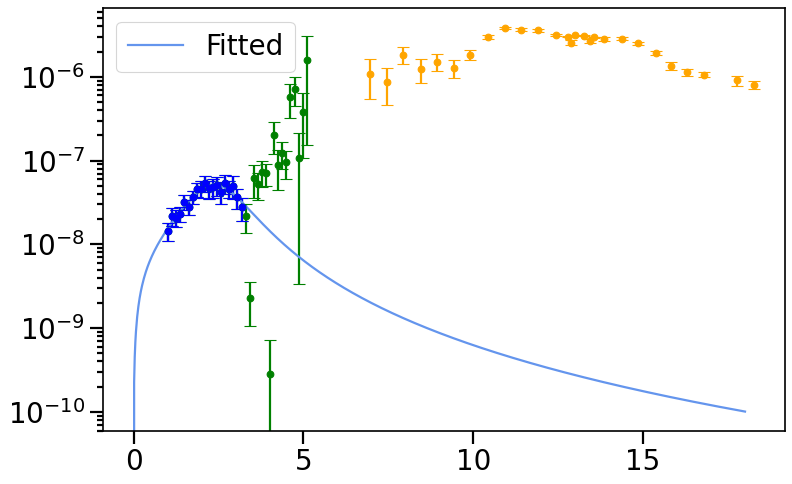

In [10]:
params_SR = lmfit.Parameters()

#                   (Name,          Value,  Weather or not to include in fit, 
#                   |               |       |     Lower fit limit, 
#                   |               |       |     |            Upper fit limit)
params_SR.add_many(('E_SR',         p0[13], True, minimum[13], maximum[13]),
                   ('Gamma_SR',     p0[14], True,  minimum[14], maximum[14]),
                   ('sigma_SR',     p0[15], True,  minimum[15], maximum[15]), 
                   ('T_f',          p0[0],  True, minimum[0],  maximum[0]))

low_cut_SR = 0
hi_cut_SR = 19

def f_fit_SR(par, E = energy_gsf_ompy[low_cut_SR:hi_cut_SR]):
    """ Marianne: make_fit currently supports up to 5 GLO/SLOs. To add more, continue the pattern. This 
    was, suprisingly, the best solution I found atm working with the scipy-syntax. """

    functions = p0_functions

    T = par['T_f']
    EX = np.array([par['E_SR']])
    Gamma = np.array([par['Gamma_SR']])
    sigma = np.array([par['sigma_SR']])

    # Calculating the sum of the singular GLOs
    output = np.zeros(len(E))
    output += functions[4](E, EX[0], Gamma[0], sigma[0], T)
    return output

def f_residuals(parameters):
    return (f_fit_SR(parameters) - gsf_ompy_median[low_cut_SR:hi_cut_SR])**2/(gsf_ompy_error[low_cut_SR:hi_cut_SR]**2)

results = lmfit.minimize(fcn=f_residuals, params=params_SR, method="least_squares")
print(results.params.pretty_print())

plt.rcParams['text.usetex'] = False
# Initialize figure!
plt.figure(figsize=(11,7))
ax = plt.subplot(111)


# Actual best-fit curve
# Extract values from the fit
# Plot the total optimalized fit
x_values_cont = np.linspace(0, 18, 1000)
plot_fit = ax.plot(x_values_cont, f_fit_SR(results.params, E=x_values_cont), '-', color="cornflowerblue", label="Fitted")
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, fmt='o', color='green')
ax.errorbar(x=energy_gsf_ompy[low_cut_SR:hi_cut_SR], y=gsf_ompy_median[low_cut_SR:hi_cut_SR], yerr=gsf_ompy_error[low_cut_SR:hi_cut_SR], fmt='o', color='blue')
ax.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='o', color='orange')
ax.legend()
ax.set_yscale('log')

print(results.params.pretty_print())
print(p0)
print(len(p0))
p0[13:16] = [results.params['E_SR'].value, results.params['Gamma_SR'].value, results.params['sigma_SR'].value]
print(p0)
print(len(p0))

In [11]:
minimum = np.array(p0)*1e-5
maximum = np.array(p0)*1e5
params = lmfit.Parameters()

#                (Name,          Value,  Weather or not to include in fit, 
#                 |              |       |     Lower fit limit, 
#                 |              |       |     |            Upper fit limit)
params.add_many(('T_f',          p0[0],  False, minimum[0],  maximum[0]),
                ('E_GLo1',       p0[1],  False, minimum[1],  maximum[1]),
                ('Gamma_GLo1',   p0[2],  False, minimum[2],  maximum[2]),
                ('sigma_GLo1',   p0[3],  False, minimum[3],  maximum[3]),
                ('E_GLo2',       p0[4],  False, minimum[4],  maximum[4]),
                ('Gamma_GLo2',   p0[5],  False, minimum[5],  maximum[5]),
                ('sigma_GLo2',   p0[6],  False, minimum[6],  maximum[6]),
                ('E_pyg1',       p0[7],  True, minimum[7],  maximum[7]),
                ('Gamma_pyg1',   p0[8],  True, minimum[8],  maximum[8]),
                ('sigma_pyg1',   p0[9],  True, minimum[9],  maximum[9]),
                ('E_pyg2',       p0[10], True, minimum[10], maximum[10]),
                ('Gamma_pyg2',   p0[11], True, minimum[11], maximum[11]),
                ('sigma_pyg2',   p0[12], True, minimum[12], maximum[12]),
                ('E_SR',         p0[13], True, p0[13]*0.9, p0[13]*1.2),
                ('Gamma_SR',     p0[14], True, p0[14]*0.5, p0[14]*1.5),
                ('sigma_SR',     p0[15], True, p0[15]*0.5, p0[15]*1.5))


#                ('E_SR',         p0[13], True, minimum[13], maximum[13]),
#                ('Gamma_SR',     p0[14], True, minimum[14], maximum[14]),
#                ('sigma_SR',     p0[15], True, minimum[15], maximum[15]))


In [12]:
def f_fit_total(par, E = x_values):

    functions = p0_functions

    T = par['T_f']
    EX = np.array(   [par['E_GLo1'],     par['E_GLo2'],     par['E_pyg1'],     par['E_pyg2'],     par['E_SR']])
    Gamma = np.array([par['Gamma_GLo1'], par['Gamma_GLo2'], par['Gamma_pyg1'], par['Gamma_pyg2'], par['Gamma_SR']])
    sigma = np.array([par['sigma_GLo1'], par['sigma_GLo2'], par['sigma_pyg1'], par['sigma_pyg2'], par['sigma_SR']])

    # Calculating the sum of the singular GLOs
    output = np.zeros(len(E))
    for i in [0,1,4]:
        output += functions[i](E, EX[i], Gamma[i], sigma[i], T)
    return output

In [13]:
def f_residuals(parameters):
    return (f_fit_total(parameters) - y_values)**2/(y_errors**2)

In [14]:
results = lmfit.minimize(fcn=f_residuals, params=params, method="least_squares")

print(results.params.pretty_print())
print(results.chisqr)

Name           Value      Min      Max   Stderr     Vary     Expr Brute_Step
E_GLo1         11.47 0.0001147 1.147e+06     None    False     None     None
E_GLo2          14.1 0.000141 1.41e+06     None    False     None     None
E_SR           2.337    2.337    3.115     None     True     None     None
E_pyg1           4.5  4.5e-05  4.5e+05     None     True     None     None
E_pyg2        0.7702    7e-05    7e+05     None     True     None     None
Gamma_GLo1     2.733 2.733e-05 2.733e+05     None    False     None     None
Gamma_GLo2      2.87 2.87e-05 2.87e+05     None    False     None     None
Gamma_SR       1.056    1.056    3.168     None     True     None     None
Gamma_pyg1     68.12    4e-06    4e+04     None     True     None     None
Gamma_pyg2       1.5  1.5e-05  1.5e+05     None     True     None     None
T_f              0.5    5e-06    5e+04     None    False     None     None
sigma_GLo1       484  0.00484 4.84e+07     None    False     None     None
sigma_GLo2     301.

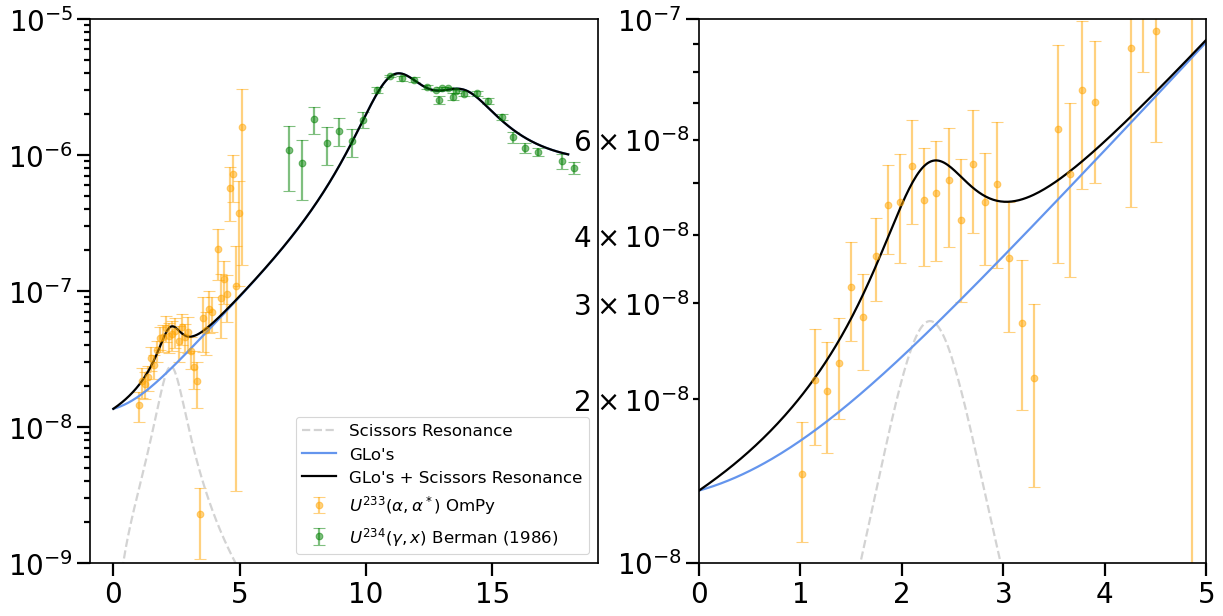

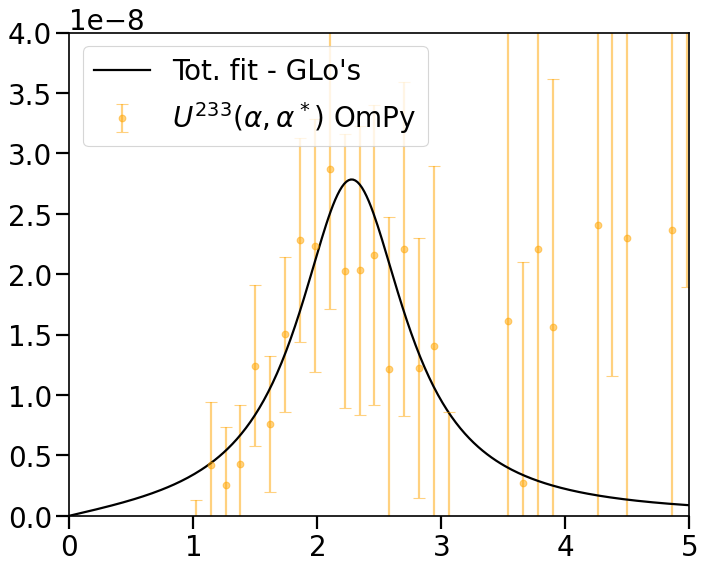

In [27]:
x_values_cont = np.linspace(0, 18, 1000)


def f_fit_plot_singular(par, E = x_values_cont, j=0):
    """ make_fit currently supports up to 5 GLO/SLOs. To add more, continue the pattern. This 
    was, suprisingly, the best solution I found atm working with the scipy-syntax. """

    functions = p0_functions

    T = par["T_f"]
    EX = np.array([par["E_GLo1"], par["E_GLo2"], par["E_pyg1"], par["E_pyg2"], par["E_SR"]])
    Gamma = np.array([par["Gamma_GLo1"], par["Gamma_GLo2"], par["Gamma_pyg1"], par["Gamma_pyg2"], par['Gamma_SR']])
    sigma = np.array([par["sigma_GLo1"], par["sigma_GLo2"], par["sigma_pyg1"], par["sigma_pyg2"], par['sigma_SR']])

    return functions[j](E, EX[j], Gamma[j], sigma[j], T)



plt.rcParams['text.usetex'] = False
# Initialize figure!
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,9))
for ax in (ax1, ax2):
    ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, fmt='o', color='orange', alpha=0.5, label='$U^{233}(\\alpha,\\alpha^*)$ OmPy')
    ax.errorbar(x=energy_exp1, y=gsf_exp1, yerr=gsf_exp1_error, fmt='o', color='green', alpha=0.5, label="$U^{234}(\gamma,x)$ Berman (1986)")
    ax.plot(x_values_cont, f_fit_plot_singular(results.params, E=x_values_cont, j=4),'--', color="lightgray", label='Scissors Resonance')
    ax.plot(x_values_cont, f_fit_GLo(results.params, E=x_values_cont), '-', color="cornflowerblue", label="GLo's")
    ax.plot(x_values_cont, f_fit_total(results.params, E=x_values_cont), '-', color="Black", label="GLo's + Scissors Resonance")
    ax.set_yscale('log')
    
ax1.legend(fontsize=15)    
ax1.set_ylim(1e-9, 1e-5)
ax2.set_ylim(1e-8, 1e-7)
ax2.set_xlim(0,5)


fig, ax = plt.subplots()
ax.plot(x_values_cont, f_fit_total(results.params, E=x_values_cont)-f_fit_GLo(results.params, E=x_values_cont)
        , '-', color="Black", label="Tot. fit - GLo's")
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median-f_fit_GLo(results.params, E=energy_gsf_ompy), yerr=gsf_ompy_error, 
            fmt='o', color='orange', alpha=0.5, label='$U^{233}(\\alpha,\\alpha^*)$ OmPy')

ax.set_ylim(0, 4e-8)
ax.set_xlim(0,5)
ax.legend()

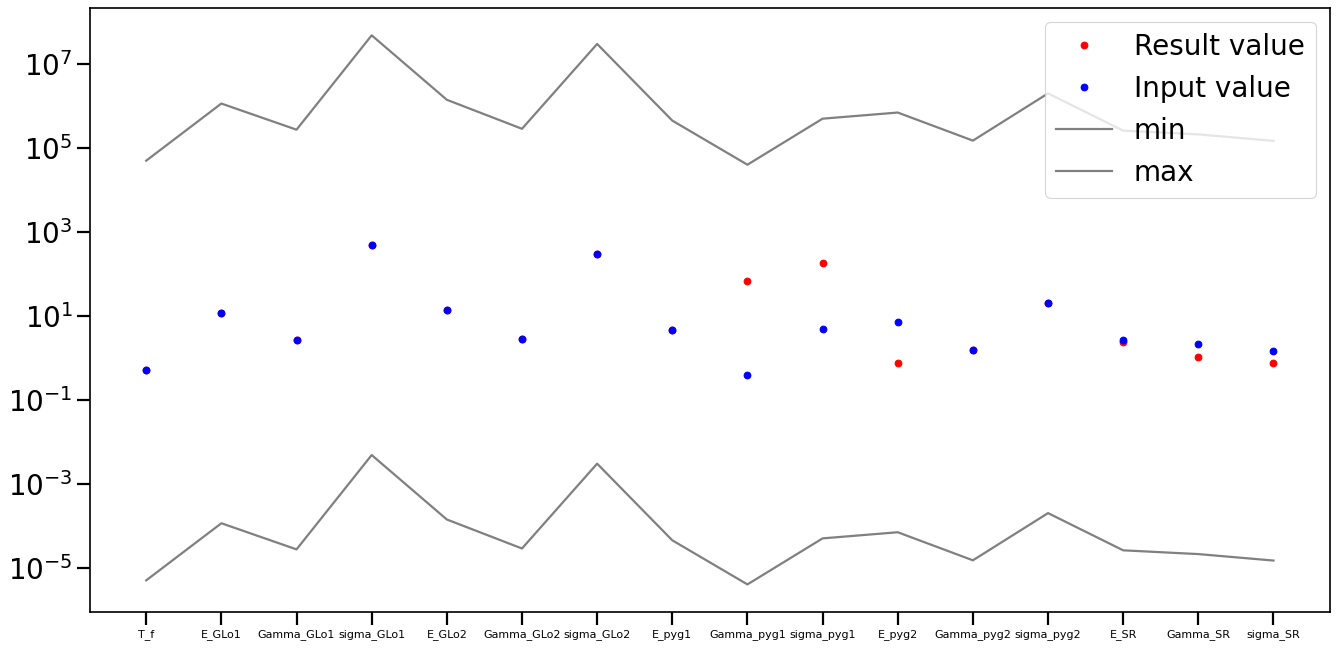

In [16]:
debug_mode=1
if debug_mode:
    """ This plots out the initial guess and optimised parameters and their min/max limits for the fit.
    This is meant to """
    fig, ax = plt.subplots(figsize=(20,10))
    
    D = params.valuesdict()
    X = range(len(D))
    R = results.params.valuesdict()
    ax.plot(X, list(R.values()), 'ro', label='Result value')
    ax.plot(X, list(D.values()), 'bo', label='Input value')
    
    ax.plot(X, minimum, color="grey", label="min")
    ax.plot(X, maximum, color="grey", label="max")

    
    ax.set_xticks(X)
    ax.tick_params(axis='x', which='major', labelsize=10, direction='out')
    ax.set_xticklabels(list(R.keys()))
    
    ax.set_yscale("log")
    ax.legend()
    fig.show()